data loaded
feature engineering completed
=== Random Forest Performance ===
Accuracy:  0.960
Precision: 0.077
Recall:    0.868
F1 Score:  0.141
ROC AUC:   0.976


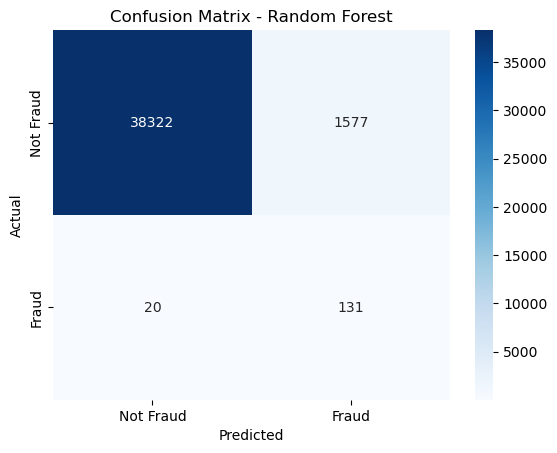

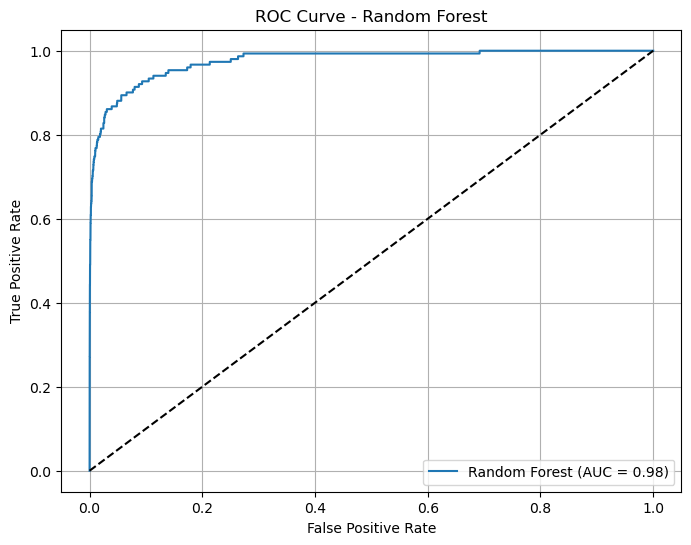

In [3]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 2: Load Datasets
users = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\users.csv")           
transactions = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\transactions.csv")  
fraudsters = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\fraudsters.csv")  
print("data loaded")

# STEP 3: Feature Engineering
fraud_ids = set(fraudsters['USER_ID'])

txn_grp = transactions.groupby('USER_ID')
user_features = txn_grp.agg(
    trans_count=('ID', 'count'),
    total_amount=('AMOUNT_GBP', 'sum'),
    avg_amount=('AMOUNT_GBP', 'mean'),
    failed_count=('STATE', lambda x: (x == 'FAILED').sum()),
    currency_count=('CURRENCY', pd.Series.nunique)
).reset_index()
user_features['fail_rate'] = user_features['failed_count'] / user_features['trans_count']

type_dummies = pd.get_dummies(transactions['TYPE'])
type_counts = transactions[['USER_ID']].join(type_dummies).groupby('USER_ID').sum().reset_index()

features = pd.merge(user_features, type_counts, on='USER_ID', how='left')
features = pd.merge(features, users, left_on='USER_ID', right_on='ID', how='left')
today = datetime(2025, 5, 15)
features['CREATED_DATE'] = pd.to_datetime(features['CREATED_DATE'], errors='coerce')
features['BIRTH_DATE'] = pd.to_datetime(features['BIRTH_DATE'], errors='coerce')
if features['CREATED_DATE'].isnull().any() or features['BIRTH_DATE'].isnull().any():
    print("Warning: Some dates failed to parse. Check the original data format.")
features['account_age_days'] = (today - features['CREATED_DATE']).dt.days
features['user_age'] = ((today - features['BIRTH_DATE']).dt.days / 365).astype(int)

features.drop(['CREATED_DATE', 'BIRTH_DATE', 'ID'], axis=1, inplace=True)
features = pd.get_dummies(features, columns=['COUNTRY'], prefix='Country')
features['is_fraud'] = features['USER_ID'].isin(fraud_ids).astype(int)
features.drop('USER_ID', axis=1, inplace=True)

print("feature engineering completed")

# STEP 4: Train-Test Split and Scaling
X = features.drop('is_fraud', axis=1)
y = features['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 5: Train Random Forest Model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    random_state=42,
    class_weight='balanced',  # handles imbalance
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# STEP 6: Predictions and Evaluation
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("=== Random Forest Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")

# STEP 7: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# STEP 8: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()
